GATA3 : 4359 , XBP1 : 4404


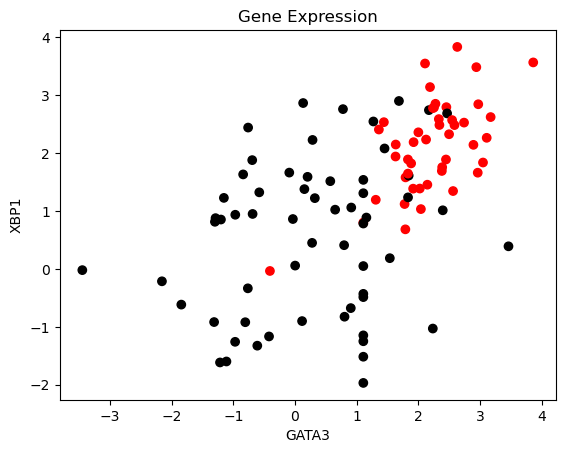

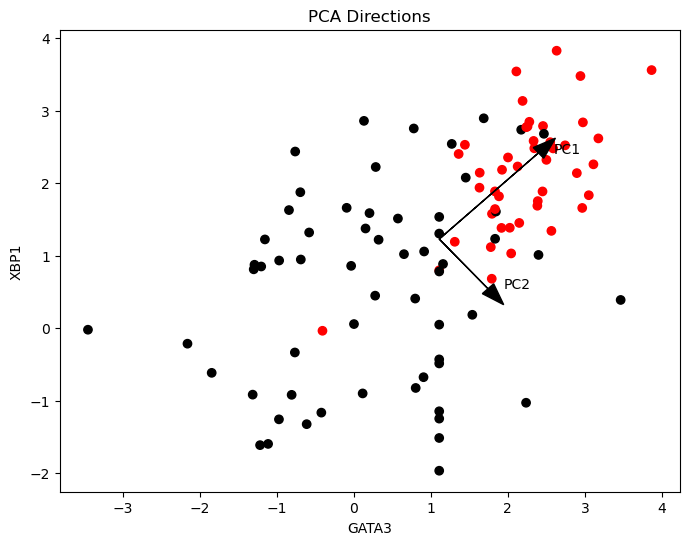

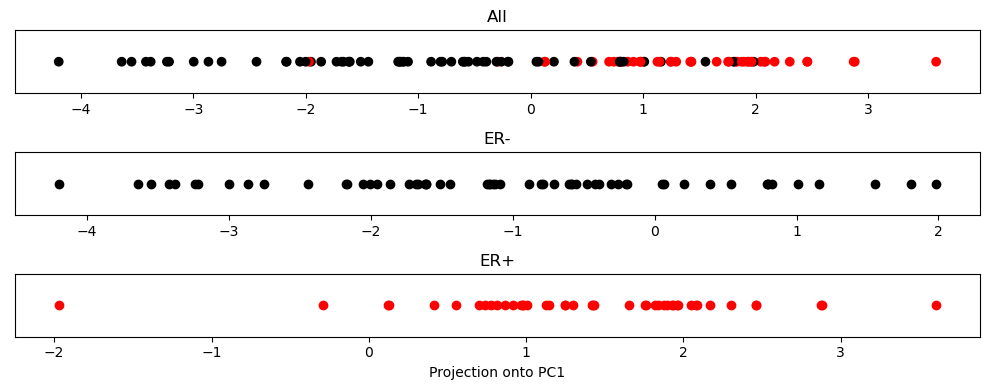

Variance explained by PC1: 0.7792
Variance explained by PC2: 0.2208


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from io import StringIO
CLASSES = pd.read_csv('class.tsv', sep='\t', header=None)
LABELS = CLASSES[0].values

with gzip.open('columns.tsv.gz', 'rt') as f:
    lines = [line for line in f if not line.startswith('#')]

temp = StringIO(''.join(lines))
MAP = pd.read_csv(temp, sep='\t')

with gzip.open('filtered.tsv.gz', 'rt') as f:
    DATA = pd.read_csv(f, sep='\t', index_col=0)

DATA.columns = DATA.columns.astype(str)
DATA.columns = DATA.columns.str.strip() 

# # Find gene IDs
XBP1 = 4404 
GATA3 = MAP[MAP['GeneSymbol'] == 'GATA3']['ID'].values[0]

xbp1_exp = DATA[str(XBP1)].values
gata3_exp = DATA[str(GATA3)].values

print(f"GATA3 : {GATA3} , XBP1 : {XBP1}")
colors = ['black' if label == 0 else 'red' for label in LABELS]
# PCA IMPLEMENTATION
def perform_pca(X):
    # preprocessing
    X = X - np.mean(X, axis = 0)
    COV_MAT = np.cov(X, rowvar=False)
    
    # Now we have to calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(COV_MAT)
    
    # Select the top k eigenvectors
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvectors, eigenvalues, X
# Scatter plot of xbp1 vs gata3
plt.scatter(gata3_exp, xbp1_exp, c=colors)
plt.xlabel('GATA3')
plt.ylabel('XBP1')
plt.title('Gene Expression')
plt.show()
x = np.column_stack((gata3_exp, xbp1_exp))

EIGENVECTORS, EIGENVALUES, X = perform_pca(x)
# Two principal components are selected
pc1 = EIGENVECTORS[:, 0]
pc2 = EIGENVECTORS[:, 1]

# projections on the principal components
pc1_proj = np.dot(X, pc1)
pc2_proj = np.dot(X, pc2)

if np.mean(pc1_proj[LABELS == 1]) < np.mean(pc1_proj[LABELS == 0]):
    pc1 = -pc1
    pc1_proj = -pc1_proj 
    plt.figure(figsize=(8, 6))
plt.scatter(gata3_exp, xbp1_exp, c=colors)

# Principal components directions
mean_gata3 = np.mean(gata3_exp)
mean_xbp1 = np.mean(xbp1_exp)
scale1 = np.sqrt(EIGENVALUES[0])
scale2 = np.sqrt(EIGENVALUES[1])

plt.arrow(mean_gata3, mean_xbp1, pc1[0]*scale1, pc1[1]*scale1, head_width=0.2, head_length=0.3, fc='black', ec='black')
plt.arrow(mean_gata3, mean_xbp1, pc2[0]*scale2, pc2[1]*scale2, head_width=0.2, head_length=0.3, fc='black', ec='black')

plt.text(mean_gata3 + pc1[0]*scale1 + 0.2, mean_xbp1 + pc1[1]*scale1, 'PC1')
plt.text(mean_gata3 + pc2[0]*scale2 + 0.2, mean_xbp1 + pc2[1]*scale2, 'PC2')

plt.xlabel('GATA3')
plt.ylabel('XBP1')
plt.title('PCA Directions')
plt.show()
# Projection on PC1

# Separate ER+ and ER- samples
er_pos_pc1 = pc1_proj[LABELS == 1]
er_neg_pc1 = pc1_proj[LABELS == 0]

plt.figure(figsize=(10, 4))

# All samples
plt.subplot(3, 1, 1)
plt.scatter(pc1_proj, np.zeros_like(pc1_proj), c=colors)
plt.yticks([])
plt.title('All')

# ER- samples
plt.subplot(3, 1, 2)
plt.scatter(er_neg_pc1, np.zeros_like(er_neg_pc1), c='black')
plt.yticks([])
plt.title('ER-')

# ER+ samples
plt.subplot(3, 1, 3)
plt.scatter(er_pos_pc1, np.zeros_like(er_pos_pc1), c='red')
plt.yticks([])
plt.title('ER+')
plt.xlabel('Projection onto PC1')

plt.tight_layout()
plt.show()

# Calculate and print variance explained
print(f"Variance explained by PC1: {EIGENVALUES[0]/sum(EIGENVALUES):.4f}")
print(f"Variance explained by PC2: {EIGENVALUES[1]/sum(EIGENVALUES):.4f}")
